In [9]:
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master


  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-dugovm50
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-dugovm50


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
!pip install -r /content/drive/'My Drive'/'Colab Notebooks'/buddy/requirements.txt

In [12]:
import sys
sys.path.append('drive/My Drive/Colab Notebooks/')
sys.path.append('drive/My Drive/Colab Notebooks/buddy')

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
from tqdm import tqdm

import torch
from transformers import AdamW
from torch.utils.data import dataloader
from buddy.dataloader.wellness import WellnessTextClassificationDataset
from buddy.model.kobert import KoBERTforSequenceClassfication

In [14]:
torch.cuda.is_available()

True

In [15]:
def train(device, epoch, model, optimizer, train_loader, save_step, save_ckpt_path, train_step = 0):
    losses = []
    train_start_index = train_step+1 if train_step != 0 else 0
    total_train_step = len(train_loader)
    model.train()

    with tqdm(total= total_train_step, desc=f"Train({epoch})") as pbar:
        pbar.update(train_step)
        for i, data in enumerate(train_loader, train_start_index):
          
            optimizer.zero_grad()
            outputs = model(**data)

            loss = outputs[0]

            losses.append(loss.item())

            loss.backward()
            optimizer.step()

            pbar.update(1)
            pbar.set_postfix_str(f"Loss: {loss.item():.3f} ({np.mean(losses):.3f})")

            if i >= total_train_step or i % save_step == 0:
                torch.save({
                    'epoch': epoch,  # 현재 학습 epoch
                    'model_state_dict': model.state_dict(),  # 모델 저장
                    'optimizer_state_dict': optimizer.state_dict(),  # 옵티마이저 저장
                    'loss': loss.item(),  # Loss 저장
                    'train_step': i,  # 현재 진행한 학습
                    'total_train_step': len(train_loader)  # 현재 epoch에 학습 할 총 train step
                }, save_ckpt_path)

    return np.mean(losses)

In [16]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [17]:
root_path = "/content/drive/MyDrive/Colab Notebooks/buddy"
data_path = f"{root_path}/data2/wellness_dialog_for_text_classification_train.txt"
checkpoint_path =f"{root_path}/checkpoint"
save_ckpt_path = f"{checkpoint_path}/kobert-wellness-text-classification-dataX-310.pth"

n_epoch = 50 #Num of Epoch
batch_size = 4 #배치 사이즈 #Colab이 돌아가지 않아 4로 했으며, 증가시켜도 무방
ctx = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(ctx)
save_step = 100 #학습 저장 주기
learning_rate = 5e-6  #Learning Rate

#WellnessTextClassificationDataset Data Loader
dataset = WellnessTextClassificationDataset(file_path=data_path, device=device)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = KoBERTforSequenceClassfication()
model.to(device)

#Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
      'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)

pre_epoch, pre_loss, train_step = 0, 0, 0
if os.path.isfile(save_ckpt_path):
    checkpoint = torch.load(save_ckpt_path, map_location=device)
    pre_epoch = checkpoint['epoch']
    train_step =  checkpoint['train_step']
    total_train_step =  checkpoint['total_train_step']

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    print(f"load pretrain from: {save_ckpt_path}, epoch={pre_epoch}")

losses = []
offset = pre_epoch
for step in range(n_epoch):
    epoch = step + offset
    loss = train(device, epoch, model, optimizer, train_loader, save_step, save_ckpt_path, train_step)
    losses.append(loss)


Train(49): 100%|██████████| 1189/1189 [03:42<00:00,  5.34it/s, Loss: 0.608 (0.021)]


,loss
0,5.512088
1,5.350970
2,5.242226
3,5.036379
4,4.744312
5,4.454038
6,4.188474
7,3.947158
8,3.707173
9,3.475132


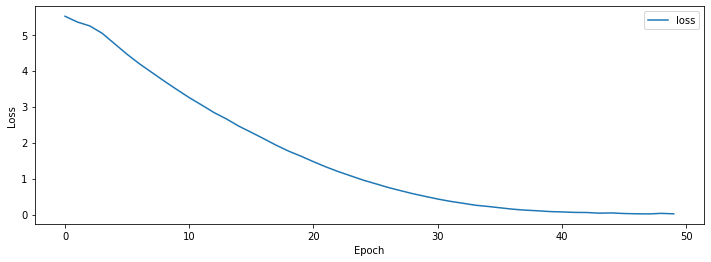

In [18]:

# data
data = {
    "loss": losses
}
df = pd.DataFrame(data)
display(df)

# graph
plt.figure(figsize=[12, 4])
plt.plot(losses, label="loss")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [19]:

import torch
import torch.nn as nn
import random

from model.kobert import KoBERTforSequenceClassfication, kobert_input
from kobert_transformers import get_tokenizer

def load_wellness_answer():
  root_path = "/content/drive/MyDrive/Colab Notebooks/buddy"
  category_path = f"{root_path}/data2/wellness_dialog_category.txt"
  answer_path = f"{root_path}/data2/wellness_dialog_answer.txt"

  c_f = open(category_path,'r')
  a_f = open(answer_path,'r')

  category_lines = c_f.readlines()
  answer_lines = a_f.readlines()

  category = {}
  answer = {}
  for line_num, line_data in enumerate(category_lines):
    data = line_data.split('    ')
    category[data[1][:-1]]=data[0]
  
  for line_num, line_data in enumerate(answer_lines):
    data = line_data.split('    ')
    keys = answer.keys()
    if(data[0] in keys):
      answer[data[0]] += [data[1][:-1]]
    else:
      answer[data[0]] = [data[1][:-1]]

  return category, answer

if __name__ == "__main__":
  root_path = "/content/drive/MyDrive/Colab Notebooks/buddy"
  checkpoint_path =f"{root_path}/checkpoint"
  save_ckpt_path = f"{checkpoint_path}/kobert-wellness-text-classification-dataX-310.pth"

  #답변과 카테고리 불러오기
  category, answer = load_wellness_answer()

  ctx = "cuda" if torch.cuda.is_available() else "cpu"
  device = torch.device(ctx)

  # 저장한 Checkpoint 불러오기
  checkpoint = torch.load(save_ckpt_path, map_location=device)

  model = KoBERTforSequenceClassfication()
  model.load_state_dict(checkpoint['model_state_dict'])

  model.to(ctx)
  model.eval()

  tokenizer = get_tokenizer()

  while 1:
    sent = input('\nQuestion: ') # '요즘 기분이 우울한 느낌이에요'
    data = kobert_input(tokenizer, sent, device, 512)

    if '종료' in sent:
      break

    output = model(**data)

    logit = output[0]
    softmax_logit = torch.softmax(logit,dim=-1)
    softmax_logit = softmax_logit.squeeze()

    max_index = torch.argmax(softmax_logit).item()
    max_index_value = softmax_logit[torch.argmax(softmax_logit)].item()

    answer_list = answer[category[str(max_index)]]
    answer_len= len(answer_list)-1
    answer_index = random.randint(0,answer_len)
    print(f'Answer: {answer_list[answer_index]}, index: {max_index}, softmax_value: {max_index_value}')
    print('-'*50)



KeyboardInterrupt: ignored

평가함수


In [20]:
import os
import logging
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
from tqdm import tqdm

import torch
from transformers import (
  AdamW,
  ElectraConfig,
  ElectraTokenizer
)
from torch.utils.data import dataloader
from dataloader.wellness import WellnessTextClassificationDataset
#from model.koelectra import koElectraForSequenceClassification
from model.kobert import KoBERTforSequenceClassfication
from kobert_transformers import get_tokenizer

logger = logging.getLogger(__name__)


MODEL_CLASSES ={
  #"koelectra": (ElectraConfig, koElectraForSequenceClassification, ElectraTokenizer),
  "kobert": (KoBERTforSequenceClassfication)
}
CHECK_POINT ={
  #"koelectra": "/content/drive/MyDrive/Colab Notebooks/buddy/checkpoint/koelectra-wellnesee-text-classification.pth",
  "kobert": "/content/drive/MyDrive/Colab Notebooks/buddy/checkpoint/kobert-wellness-text-classification-dataX-310.pth"
}

def get_model_and_tokenizer(model_name, device):
  save_ckpt_path = CHECK_POINT[model_name]

#  if model_name== "koelectra":
#    model_name_or_path = "monologg/koelectra-base-discriminator"

#    tokenizer = ElectraTokenizer.from_pretrained(model_name_or_path)
#    electra_config = ElectraConfig.from_pretrained(model_name_or_path)
#    model = koElectraForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path,
#                                                               config=electra_config,
#                                                               num_labels=359)
  if model_name =='kobert':
    tokenizer = get_tokenizer()
    model = KoBERTforSequenceClassfication()

  if os.path.isfile(save_ckpt_path):
      checkpoint = torch.load(save_ckpt_path, map_location=device)
      pre_epoch = checkpoint['epoch']
      # pre_loss = checkpoint['loss']
      model.load_state_dict(checkpoint['model_state_dict'])

      print(f"load pretrain from: {save_ckpt_path}, epoch={pre_epoch}")

  return model, tokenizer

def get_model_input(data):
  if model_name =='kobert':
    return data
#  elif model_name== "koelectra":
#    return {'input_ids': data['input_ids'],
#              'attention_mask': data['attention_mask'],
#              'labels': data['labels']
#              }

def evaluate(model_name, device, batch_size, data_path):

  model, tokenizer = get_model_and_tokenizer(model_name, device)
  model.to(device)

  # WellnessTextClassificationDataset 데이터 로더
  eval_dataset = WellnessTextClassificationDataset(file_path=data_path,device=device, tokenizer=tokenizer)
  eval_dataloader = torch.utils.data.DataLoader(eval_dataset, batch_size=batch_size, shuffle=True)

  logger.info("***** Running evaluation on %s dataset *****")
  logger.info("  Num examples = %d", len(eval_dataset))
  logger.info("  Batch size = %d", batch_size)

  loss = 0
  acc = 0


  # model.eval()
  for data in tqdm(eval_dataloader, desc="Evaluating"):
    with torch.no_grad():
      inputs = get_model_input(data)
      outputs = model(**inputs)
      loss += outputs[0]
      logit = outputs[1]
      acc += (logit.argmax(1)==inputs['labels']).sum().item()

  return loss / len(eval_dataset), acc / len(eval_dataset)

if __name__ == '__main__':
  #root_path = "/content/drive/MyDrive/Colab Notebooks/buddy/data"
  root_path = "/content/drive/MyDrive/Colab Notebooks/buddy"
  data_path = f"{root_path}/data2/wellness_dialog_for_text_classification_test.txt"
  checkpoint_path = f"{root_path}/checkpoint"
  save_ckpt_path = f"{checkpoint_path}/kobert-wellness-text-classification-dataX-310.pth"
  #model_name_or_path = "monologg/koelectra-base-discriminator"

  n_epoch = 50  # Num of Epoch
  batch_size = 16  # 배치 사이즈
  ctx = "cuda" if torch.cuda.is_available() else "cpu"
  device = torch.device(ctx)
  model_names=["kobert"]
  for model_name in model_names:
    eval_loss, eval_acc = evaluate(model_name, device, batch_size, data_path)
    print(f'\tLoss: {eval_loss:.4f}(valid)\t|\tAcc: {eval_acc * 100:.1f}%(valid)')

load pretrain from: /content/drive/MyDrive/Colab Notebooks/buddy/checkpoint/kobert-wellness-text-classification-dataX-310.pth, epoch=49


Evaluating: 100%|██████████| 29/29 [00:04<00:00,  6.33it/s]

	Loss: 0.2383(valid)	|	Acc: 37.6%(valid)
